# Imports

In [16]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pylab import rcParams
import seaborn as sns
from array import array
import math
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.stats import mannwhitneyu
import statistics
%matplotlib inline


# Useful functions

In [17]:
begins=[]
ends=[]
names =[]
with open ("CommonData/sequence.gb") as f:
    in_pep = False
    for l in f:
        if "mat_peptide" in l:
            begins.append(int(l.split()[1].split("..")[0]))
            ends.append(int(l.split()[1].split("..")[1]))
            in_pep = True
        elif in_pep :
            names.append(l.split("=")[1])
            in_pep = False
            
print(begins)
print(ends)
print(names)

[108, 474, 753, 978, 2490, 3546, 4224, 4614, 6465, 6846, 6915, 7668]
[473, 752, 977, 2489, 3545, 4223, 4613, 6464, 6845, 6914, 7667, 10376]
['"capsid"\n', '"propeptide"\n', '"membrane"\n', '"envelope"\n', '"NS1"\n', '"NS2A"\n', '"NS2B"\n', '"NS3"\n', '"NS4A"\n', '"2K"\n', '"NS4B"\n', '"NS5"\n']


In [155]:
# Interesting positions
#positions=[316,1670,1785,2340,5935,7172,8449,9165]
positions = [1670, 2340, 5662, 7172, 10006, 2193, 1785]
def plot_positions():
    for x in positions:
        plt.axvline(x=x, linewidth=1, linestyle=':')
        
def plot_genes():
    for i in range(len(begins)):
        plt.plot([begins[i], begins[i]], [0.99,1.0], linewidth=2, linestyle='-', color="black")
        if i%2==0:
            plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.005, (names[i].replace('"', ''))[0:3], size='xx-small')
        else:
            plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.015, (names[i].replace('"', ''))[0:3], size='xx-small')
    plt.plot([ends[-1], ends[-1]], [0.99,1.0], linewidth=2, linestyle='-', color="black")



In [19]:
def synonymous (row):
    if row['null'] or (row['Consensus_aa']==row['Secondbase_aa'] ):
        return "synonymous" 
    else:
        return "non-synonymous"

def add_columns(table):
    table['null'] = (table['Secondbase_aa']).isnull()
    table['is_synonymous'] = table.apply (lambda row: synonymous (row),axis=1)
    table['1_major_variant_frequency'] = 1.0 - table['Major_variant_frequency_quality_corrected']

In [20]:
def is_increasing(minor_frequencies):
    #print(minor_frequencies)
    tolerance = 0.01
    minimum_increase = 0.1
    previous = minor_frequencies[0]
    if minor_frequencies[-1] - minor_frequencies[0] < minimum_increase:
        return False
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m] or previous < minor_frequencies[m] + tolerance:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True


# Strict definition of an increasing position
def is_strictly_increasing(minor_frequencies):
    #print(minor_frequencies)
    previous = minor_frequencies[0]
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m]:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True


def get_variant_frequency(variant, table, i):
    sum_of_bases = table['As_quality_corrected'][i]+table['Cs_quality_corrected'][i]+table['Gs_quality_corrected'][i]+table['Ts_quality_corrected'][i]+table['Ns_quality_corrected'][i]
    if variant == "A":
        return table["As_quality_corrected"][i] / sum_of_bases
    elif variant == "C":
        return table["Cs_quality_corrected"][i] / sum_of_bases
    elif variant == "G":
        return table["Gs_quality_corrected"][i] / sum_of_bases
    elif variant == "T":
        return table["Ts_quality_corrected"][i] / sum_of_bases
    else:
        return np.nan
        

def get_increasing_variants(tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    increasingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        if major == last["Major_variant"][i]:
            minor = last["Second_variant"][i]
        else:
            minor = last["Major_variant"][i]
        minor_frequencies[0] = get_variant_frequency(minor, first, i)
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
            minor_frequencies[table_id] = get_variant_frequency(minor, tables[table_id], i)
        if is_increasing(minor_frequencies):
            increasingVariants[i] = [major_frequencies.tolist(), minor_frequencies.tolist()]
    return increasingVariants


def printMajorFrequencyThroughSamples(tables, numPos):
    major = tables[0]['Major_variant'][numPos]
    last_major = tables[0]['Major_variant'][numPos]
    print("Position "+ str(numPos) +", Major variant in first sample: " + major)
    print("Position "+ str(numPos) +", Frequencies of "+major+" through the samples: ")
    for i in range(len(tables)):
        print("\t"+str(get_variant_frequency(major, tables[i], numPos)))
    print("Position "+ str(numPos) +", Major variant in last sample: " + tables[-1]['Major_variant'][numPos])

    
def printMajorFrequencyThroughSamples_2340_7172(tables):
    printMajorFrequencyThroughSamples(tables, 2340)
    printMajorFrequencyThroughSamples(tables, 7172)

# Reading the data

In [22]:
# Control runs, replicate A
DD3_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD3_A)
DD6_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD6_A)
DD9_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD9_A)
DD12_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD12_A)
DD18_A = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD18_A)
DD24_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD24_A)
DD51_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A)
DD51_A_no_reamp = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51Anoreamplification_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A_no_reamp)

tables_A = [DD3_A, DD6_A, DD9_A, DD12_A, DD18_A, DD24_A, DD51_A]
names_A = ["DD3_A", "DD6_A", "DD9_A", "DD12_A", "DD18_A", "DD24_A", "DD51_A"]


In [23]:
# Control runs, replicate D
DD3_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD3_D)
DD6_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD6_D)
DD9_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD9_D)
DD12_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD12_D)
DD18_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD18_D)
DD24_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD24_D)

tables_D = [DD3_D, DD6_D, DD9_D, DD12_D, DD18_D, DD24_D]
names_D = ["DD3_D", "DD6_D", "DD9_D", "DD12_D", "DD18_D", "DD24_D"]


In [24]:
# Control runs, replicate E
DD3_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD3E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD6_E = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD9_E = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD12_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD12E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD18_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD24_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD24E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD24crude_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD24Ecrude_1_sequence.txt.assembled.fastq_mapped_AA.csv")

add_columns(DD3_E)
add_columns(DD6_E)
add_columns(DD9_E)
add_columns(DD12_E)
add_columns(DD18_E)
add_columns(DD24_E)
add_columns(DD24crude_E)

tables_E = [DD3_E, DD6_E, DD9_E, DD12_E, DD18_E, DD24_E]
names_E = ["DD3_E", "DD6_E", "DD9_E", "DD12_E", "DD18_E", "DD24_E"]

In [25]:
# TLR3 activation runs, replicate A
TD9_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD9A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD9_A)
TD12_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD12A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD12_A)
TD18_A = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD18_A)
TD24_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD24A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD24_A)
TD51_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD51A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD51_A)

tables_TA = [TD9_A, TD12_A, TD18_A, TD24_A, TD51_A]
names_TA = ["TD9_A", "TD12_A", "TD18_A", "TD24_A", "TD51_A"]

In [26]:
# TLR3 activation runs, replicate D
TD9_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD9D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD12_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD12D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD18_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD24_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD24D_1_sequence.txt.assembled.fastq_mapped_AA.csv")

add_columns(TD9_D)
add_columns(TD12_D)
add_columns(TD18_D)
add_columns(TD24_D)

tables_TD = [TD9_D, TD12_D, TD18_D, TD24_D]
names_TD = ["TD9_D", "TD12_D", "TD18_D", "TD24_D"]

In [27]:
# TLR3 activation runs, replicate E
TD9_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD9E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD12_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD12E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD18_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD24_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD24E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD9_E)
add_columns(TD12_E)
add_columns(TD18_E)
add_columns(TD24_E)

tables_TE = [TD9_E, TD12_E, TD18_E, TD24_E]

names_TE= [ "TD9_E", "TD12_E", "TD18_E", "TD24_E"]


In [13]:
# All tables
all_tables = tables_A+tables_D+tables_E+tables_TA+tables_TD+tables_TE
all_table_names = ["DD3_A", "DD6_A", "DD9_A", "DD12_A", "DD18_A", "DD24_A", "DD51_A", "DD3_D", "DD6_D", "DD9_D", "DD12_D", "DD18_D", "DD24_D", "DD3_E", "DD6_E", "DD9_E", "DD12_E", "DD18_E", "DD24_E", "TD9_A", "TD12_A", "TD18_A", "TD24_A", "TD51_A", "TD9_D", "TD12_D", "TD18_D", "TD24_D", "TD9_E", "TD12_E", "TD18_E", "TD24_E"]

# Coverage plots

In [44]:
def plotCoverage(tables, names):
    variable = 'Coverage'
    sample = list()
    posList = list()
    variableList = list()
    for i in range(len(names)):
        sample = sample + len(tables[i][variable]) * [names[i]]
        posList.append(tables[i]['Position'])
        variableList.append(tables[i][variable])
    positions = pd.concat(posList)
    variableValues = pd.concat(variableList)
    overlay_table_concat = pd.DataFrame ({'Position':positions, variable:variableValues, 'sample':sample})
    sns.lmplot( x="Position", y=variable, data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, lowess=True,scatter_kws={"s": 20})
    plt.legend(loc='lower right')
    plot_positions()
    plot_genes()

## DD_A

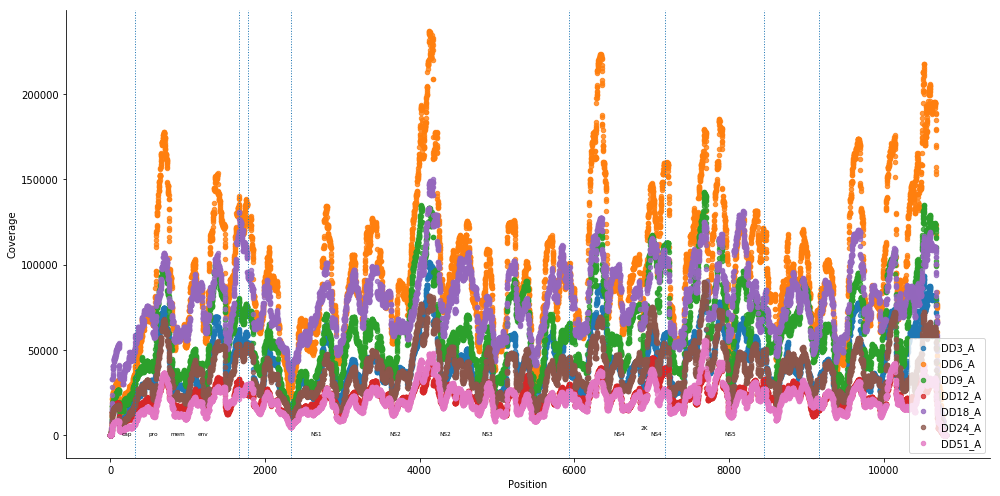

In [45]:
plotCoverage(tables_A, names_A)

## DD_D

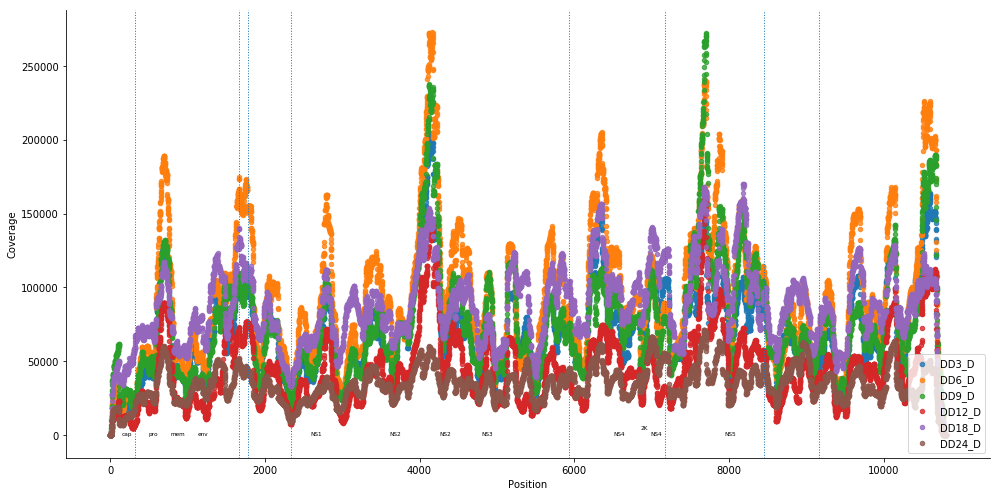

In [46]:
plotCoverage(tables_D, names_D)

## DD_E

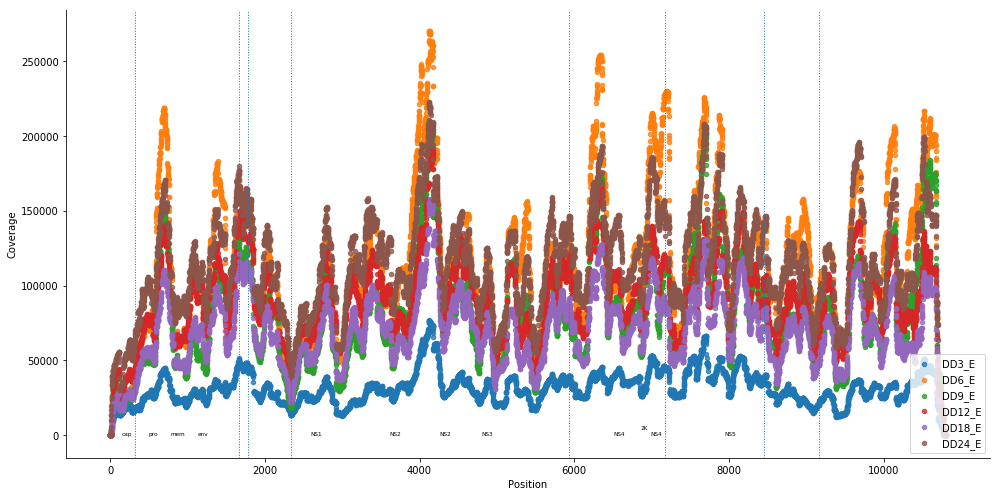

In [47]:
plotCoverage(tables_E, names_E)

## TD_A

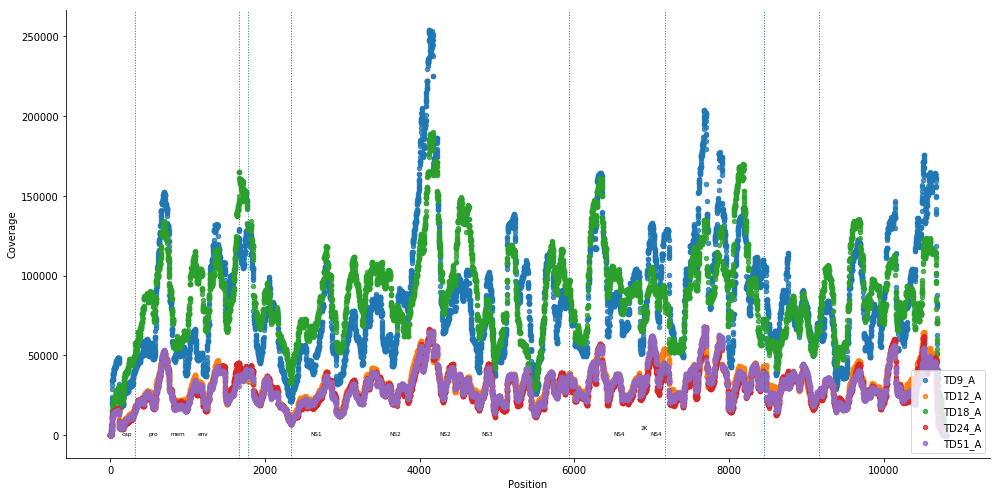

In [48]:
plotCoverage(tables_TA, names_TA)

## TD_D

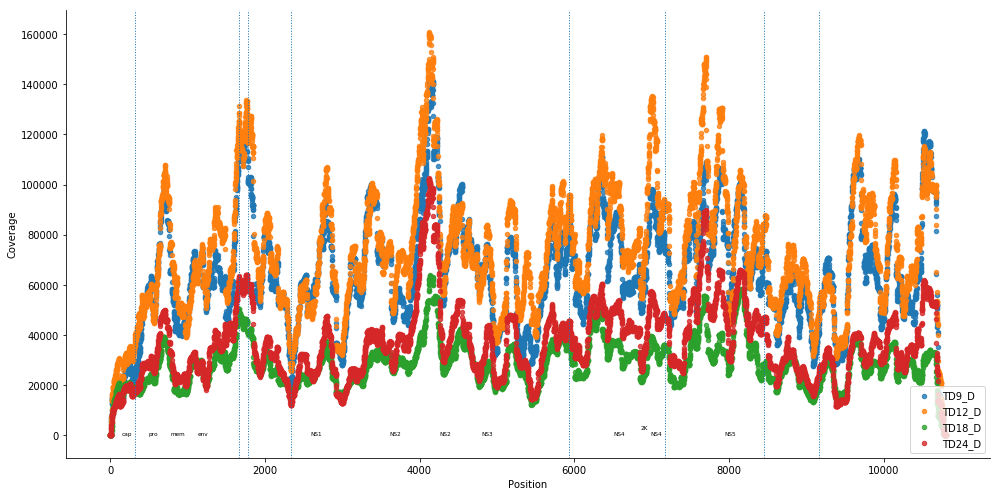

In [49]:
plotCoverage(tables_TD, names_TD)

## TD_E

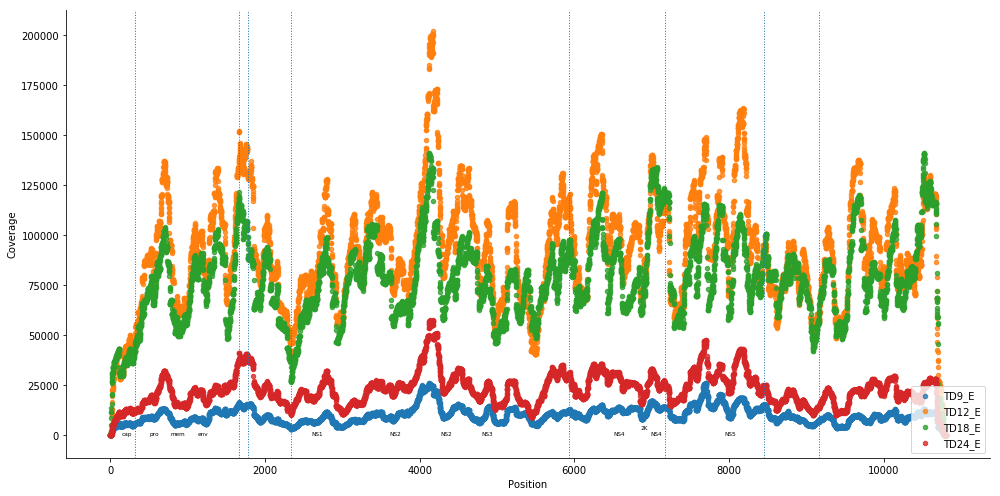

In [50]:
plotCoverage(tables_TE, names_TE)

# Figure S5

### Computing standard deviation of base frequencies at a site in an experiment

In [122]:
# Functions to think in terms of standard deviation of the frequency per site
def compute_sds(tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    sds = list()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
        sd_value = statistics.pstdev(major_frequencies)
        sds.append(sd_value)
    return sds

def get_varying_variants_sd(tables, sd_threshold):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    varyingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
        sd_value = statistics.pstdev(major_frequencies)
        if sd_value > sd_threshold:
            varyingVariants[i] = sd_value
    print("There are "+str(len(varyingVariants))+" positions whose major variant varies a lot in frequency.")
    print("Those are:")
    print(varyingVariants.keys())
    return varyingVariants


### Defining a threshold of variation

In [123]:
# Compute all standard deviations for all sites for all experiments
sds_A = compute_sds(tables_A)
sds_D = compute_sds(tables_D)
sds_E = compute_sds(tables_E)
sds_TA = compute_sds(tables_TA)
sds_TD = compute_sds(tables_TD)
sds_TE = compute_sds(tables_TE)

        

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


In [125]:
sds = list()
sds = sds + sds_A + sds_D + sds_E + sds_TA + sds_TD + sds_TE
print(len(sds))

64842


/home/boussau/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/boussau/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


[Text(0,0.5,'Density'), Text(0.5,0,'Standard deviation of base frequencies')]

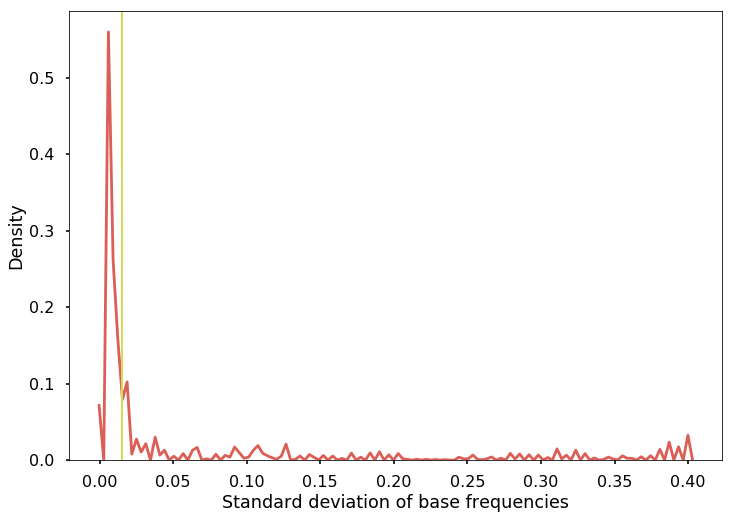

In [152]:
a4_dims = (11.7, 8.27)


fig, ax = plt.subplots(figsize=a4_dims)

sns.kdeplot(sds)
sds_threshold = 0.015
plt.plot([sds_threshold, sds_threshold], [0, 1], linewidth=2)
ax.set(xlabel='Standard deviation of base frequencies', ylabel='Density')


In [140]:
num =0
for i in sds:
    if (i>sds_threshold):
        num = num +1
print("There are "+str(num) + " pairs position*experiments that have a standard deviation larger than the threshold "+str(sds_threshold))

There are 125 pairs position*experiments that have a standard deviation larger than the threshold 0.015


### Retrieving the highly variable variants

In [142]:
varying_A = get_varying_variants_sd(tables_A, sds_threshold)
varying_D = get_varying_variants_sd(tables_D, sds_threshold)
varying_E = get_varying_variants_sd(tables_E, sds_threshold)
varying_TA = get_varying_variants_sd(tables_TA, sds_threshold)
varying_TD = get_varying_variants_sd(tables_TD, sds_threshold)
varying_TE = get_varying_variants_sd(tables_TE, sds_threshold)


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


There are 19 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([276, 316, 1419, 1632, 1670, 1785, 2177, 2340, 2593, 4691, 4708, 5662, 5935, 6044, 7172, 8449, 9165, 10006, 10787])
There are 33 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([286, 287, 289, 290, 291, 292, 293, 294, 297, 298, 299, 300, 301, 303, 304, 318, 533, 926, 1785, 1916, 2069, 2177, 2185, 2193, 2340, 2935, 5662, 6558, 7172, 8466, 8710, 9703, 10006])
There are 17 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([207, 346, 533, 768, 860, 1785, 2193, 2340, 2359, 3566, 3709, 4297, 5479, 5662, 7172, 9620, 10006])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


There are 23 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([8, 9, 10, 11, 284, 860, 1419, 1670, 1785, 1874, 2089, 2102, 2177, 2340, 3709, 4606, 5662, 5934, 6316, 7172, 8519, 9526, 10006])
There are 18 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([860, 943, 1397, 1419, 1436, 1670, 1785, 1883, 2078, 2340, 3558, 4691, 5662, 7172, 7621, 7792, 9564, 10006])
There are 15 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([8, 1033, 1397, 1785, 2177, 2193, 2287, 2340, 3670, 5359, 5662, 6193, 7172, 8869, 10006])


In [143]:
all_varying = [varying_A,varying_D,varying_E,varying_TA,varying_TD,varying_TE]
def build_table_for_plotting_varying_pos (all_varying):
    all_keys = list()
    for di in all_varying:
        all_keys = all_keys + list(di.keys())
    return(Counter(all_keys))
counts = build_table_for_plotting_varying_pos(all_varying)
print (counts)

Counter({1785: 6, 2340: 6, 5662: 6, 7172: 6, 10006: 6, 2177: 4, 1419: 3, 1670: 3, 2193: 3, 860: 3, 4691: 2, 533: 2, 3709: 2, 8: 2, 1397: 2, 276: 1, 316: 1, 1632: 1, 2593: 1, 4708: 1, 5935: 1, 6044: 1, 8449: 1, 9165: 1, 10787: 1, 286: 1, 287: 1, 289: 1, 290: 1, 291: 1, 292: 1, 293: 1, 294: 1, 297: 1, 298: 1, 299: 1, 300: 1, 301: 1, 303: 1, 304: 1, 318: 1, 926: 1, 1916: 1, 2069: 1, 2185: 1, 2935: 1, 6558: 1, 8466: 1, 8710: 1, 9703: 1, 207: 1, 346: 1, 768: 1, 2359: 1, 3566: 1, 4297: 1, 5479: 1, 9620: 1, 9: 1, 10: 1, 11: 1, 284: 1, 1874: 1, 2089: 1, 2102: 1, 4606: 1, 5934: 1, 6316: 1, 8519: 1, 9526: 1, 943: 1, 1436: 1, 1883: 1, 2078: 1, 3558: 1, 7621: 1, 7792: 1, 9564: 1, 1033: 1, 2287: 1, 3670: 1, 5359: 1, 6193: 1, 8869: 1})


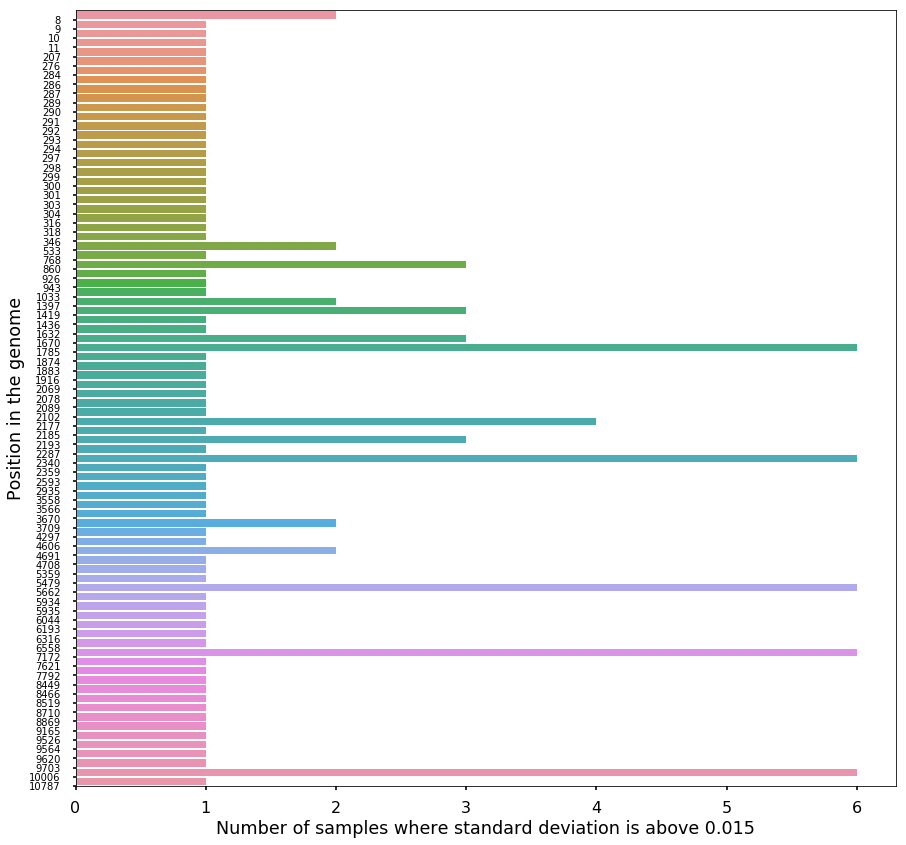

In [151]:

counts_sorted = sorted(counts.items())

labels, values = zip(*counts_sorted)

indexes = np.arange(len(labels))
width = 1


sns.set_palette("hls")
sns.set_context("poster")

a4_dims = (14.7, 14.27)

to_plot = pd.DataFrame ({'Position':indexes, 'standard_deviation':values}) 

fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(y="Position", x="standard_deviation", data=to_plot, orient="h")
ax.set(xlabel='Number of samples where standard deviation is above ' + str(sds_threshold), ylabel='Position in the genome')
plt.yticks(indexes + width * 0.5, labels, size=10)
plt.show()

Positions 2340, 5662, 7172 and 10006 vary a lot in all 6 experiments.

# Figure 5

In [ ]:
- refaire figure 5 : par réplicat et TD ou DD, positions 1670, 2340, 5662, 7172, 10006, 2193, 1785

In [ ]:
variable = 'Major_variant_frequency'
sample = len(clone12 [variable])*["Clone 12"]+len(clone15 [variable])*["Clone 15"]+len(clone19 [variable])*["Clone 19"]

overlay_table_concat = pd.DataFrame ({'Position':pd.concat([clone12['Position'],clone15['Position'],clone19['Position']]), variable:pd.concat([clone12 [variable],clone15 [variable], clone19 [variable] ]), 'sample':sample})



sns.lmplot( x="Position", y=variable, data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, lowess=True,scatter_kws={"s": 20})
plt.legend(loc='lower right')
plot_positions()
plot_genes()

In [173]:
def plotSecondVariant(tables, names):
    variable = 'Second_variant_frequency_quality_corrected'
    sample = list()
    posList = list()
    variableList = list()
    for i in range(len(names)):
        sample = sample + len(tables[i][variable]) * [names[i]]
        posList.append(tables[i]['Position'])
        variableList.append(tables[i][variable])
    positions = pd.concat(posList)
    variableValues = pd.concat(variableList)
    overlay_table_concat = pd.DataFrame ({'Position':positions, variable:variableValues, 'sample':sample})
    sns.lmplot( x="Position", y=variable, data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2)
#    plt.legend(loc='lower right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plot_positions()
    #plot_genes()

## D_A

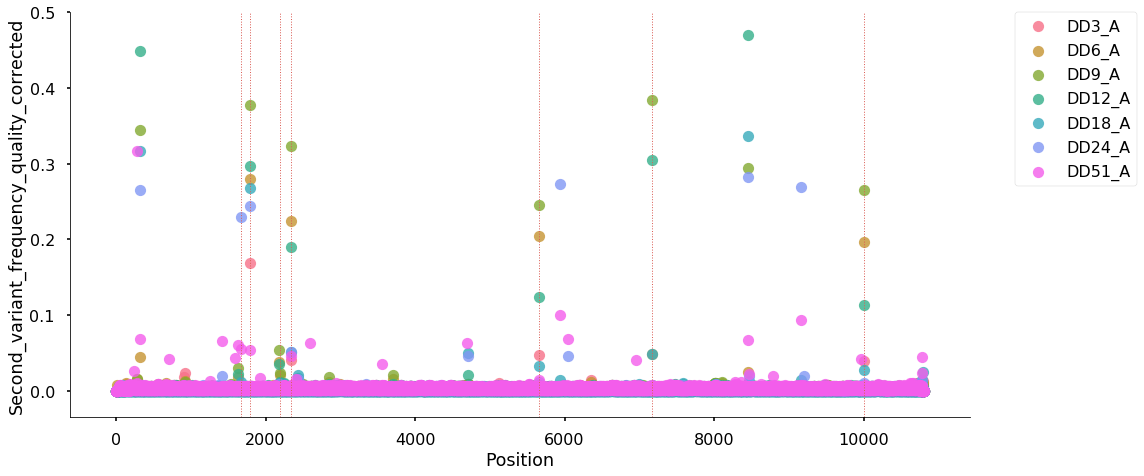

In [174]:
plotSecondVariant(tables_A, names_A)

## D_D

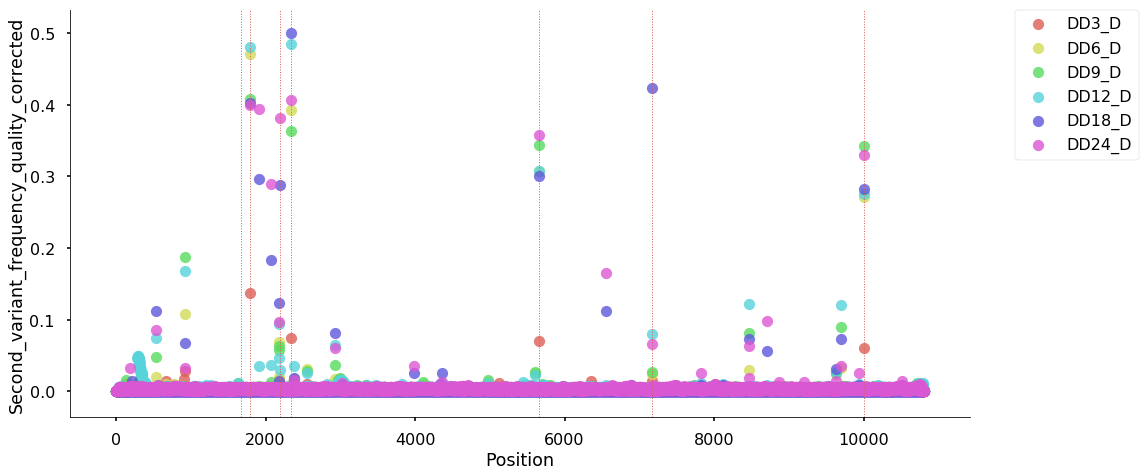

In [175]:
plotSecondVariant(tables_D, names_D)

## D_E

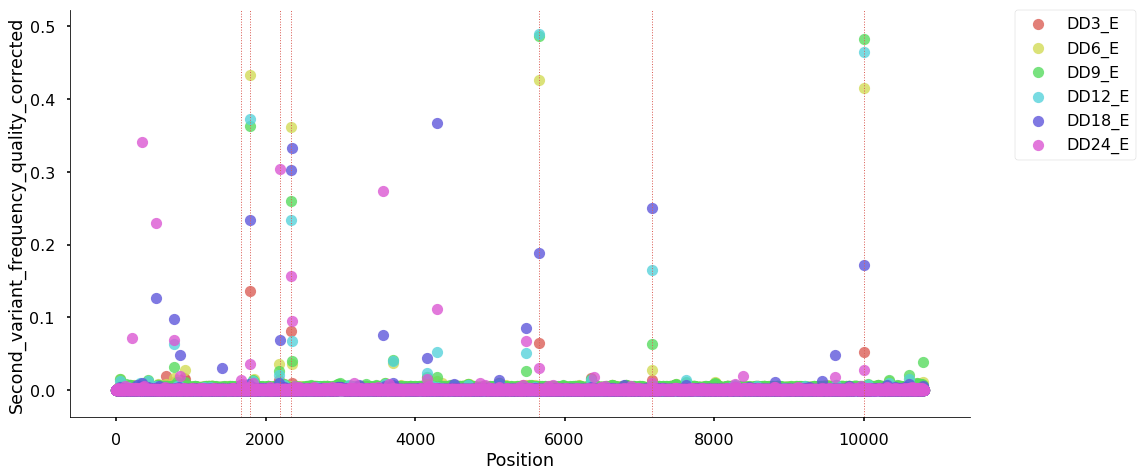

In [176]:
plotSecondVariant(tables_E, names_E)

## TD_A

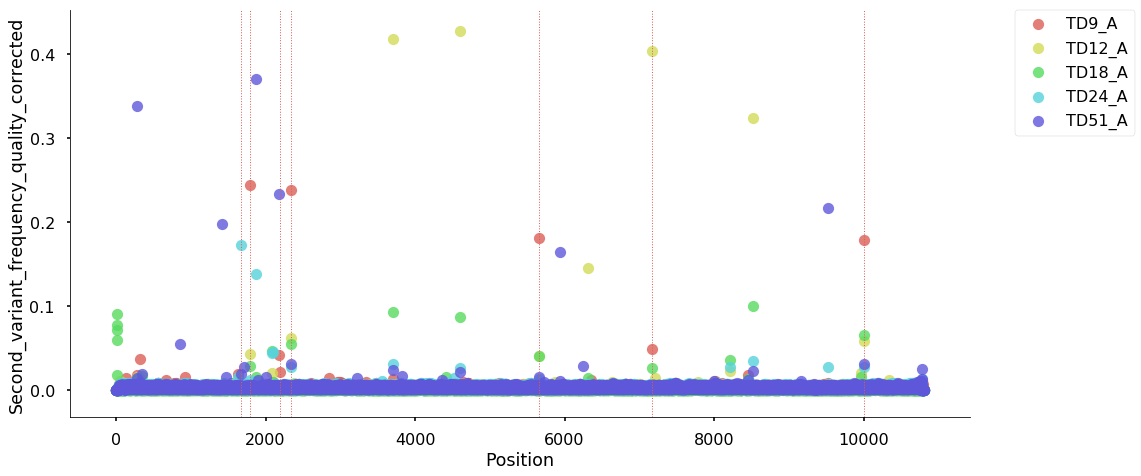

In [177]:
plotSecondVariant(tables_TA, names_TA)

## TD_D

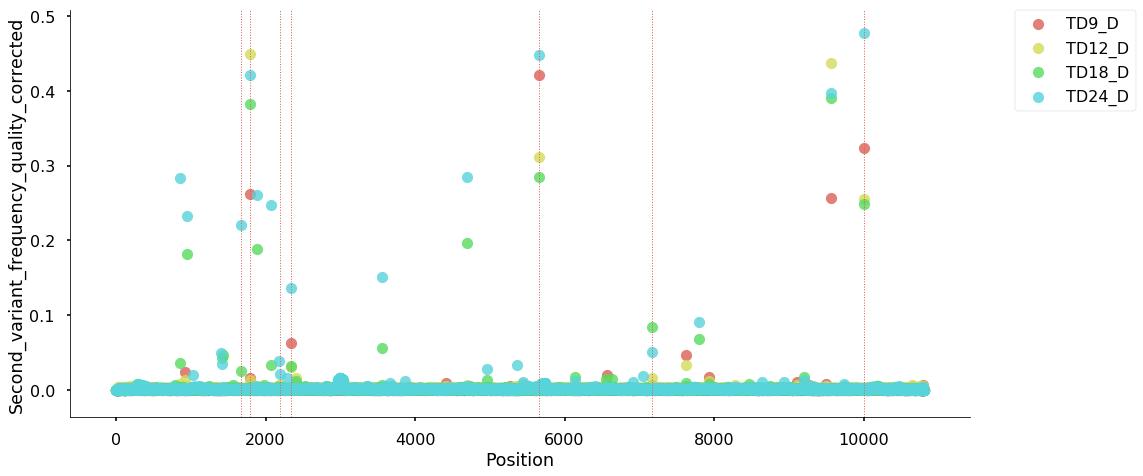

In [178]:
plotSecondVariant(tables_TD, names_TD)

## TD_E

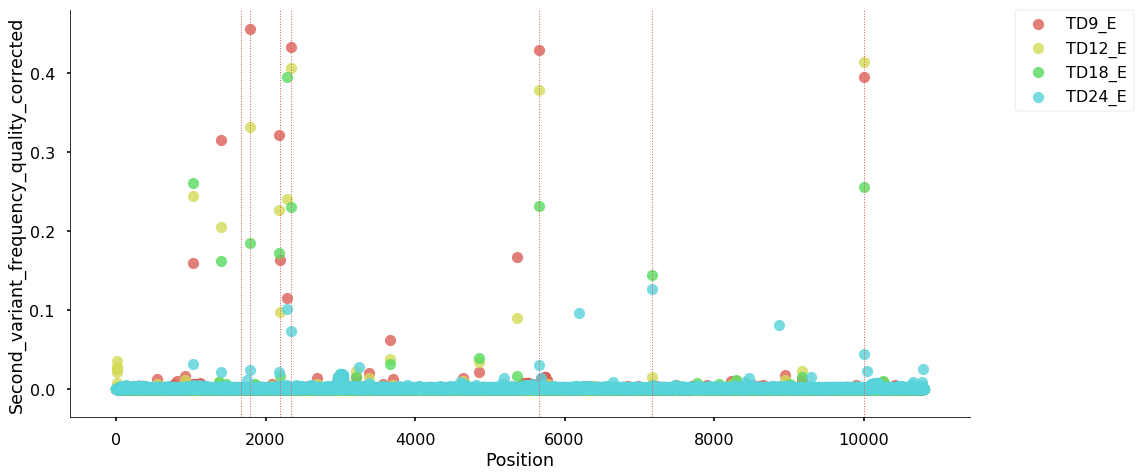

In [179]:
plotSecondVariant(tables_TE, names_TE)